# Decomposition of Sky Spectra

This notebook tests the decomposition of sky spectra into continuum and groups of sky lines whose fluxes are tied according to atomic information.

## Read `XCframe` file

And focus on one of the exposure.

In [1]:
from astropy.table import Table
from astropy.io import fits

tbl = Table.read('XCframe_1.1.1_3469_31300_1.fits', 'DRP_ALL')
wave = fits.getdata('XCframe_1.1.1_3469_31300_1.fits', 'WAVE')
flux = fits.getdata('XCframe_1.1.1_3469_31300_1.fits', 'FLUX')

# idx = 3115
idx = 2345
# idx = np.argwhere(tbl['expnum'] == 20838)[0][0] # omega Cen
# idx = np.argwhere(tbl['expnum'] == 8373)[0][0] # LMC

spec = flux[idx]
tbl[idx]

tilegrp,tileid,mjd,expnum,exptime,stage,status,drpqual,drpver,dpos,object,obstime,sci_ra,sci_dec,sci_amass,sci_kmpos,sci_focpos,sci_sh_hght,sci_moon_sep,skye_ra,skye_dec,skye_amass,skye_kmpos,skye_focpos,skye_name,skye_sh_hght,skye_moon_sep,skyw_ra,skyw_dec,skyw_amass,skyw_kmpos,skyw_focpos,skyw_name,skyw_sh_hght,skyw_moon_sep,moon_ra,moon_dec,moon_phase,moon_fli,sun_alt,moon_alt,filename,location,agcam_location,calib_mjd,Survey,Near,Far,Redshift
bytes6,int64,int64,int64,float64,int64,int64,int64,bytes5,int64,bytes24,bytes23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,bytes23,bytes77,bytes65,int64,bytes7,bytes8,bytes8,float64
1050XX,1050836,60356,12613,900.0,1,0,0,1.1.1,0,tile_id=1050836,2024-02-16T01:18:10.260,109.212822,-41.535677,1.049,-62.34,36.88,132.50235,27.2058,70.866237,-56.12374,1.176,-46.35,36.54,WHAM_south_08,126.31504,34.2329,105.655017,-36.284108,1.023,-56.81,37.41,grid154,131.37992,27.6955,45.46842,20.89865,82.46,0.4357,-22.7201,21.5916,lvmSFrame-00012613.fits,sdsswork/lvm/spectro/redux/1.1.1/1050XX/1050836/60356/lvmSFrame-00012613.fits,sdsswork/data/agcam/lco/60356/coadds/lvm.sci.coadd_s00012613.fits,60355,HighLat,SKY_WEST,SKY_EAST,0.0


## Prepare Sky Lines

In [2]:
from astropy.table import Table
data = Table.read("lvm_sky_lines_all.dat", format='ascii')
data

wave,flux_lvm,flux_eso,trans,type,electronic_state,rotational_upper_level
float64,float64,float64,float64,int64,int64,int64
3499.769,7.934e-17,0.0013,0.999431,5,39,0
3502.358,6.098e-17,0.001,0.999424,5,41,0
3502.758,7.927e-17,0.0013,0.99943,5,41,0
3504.807,4.875e-17,0.0008,0.999467,5,39,0
3505.317,3.656e-17,0.0006,0.999479,5,41,0
3505.717,7.311e-17,0.0012,0.999482,5,41,0
3508.916,5.478e-17,0.0009,0.999497,5,41,0
3509.846,6.085e-17,0.001,0.999463,5,41,0
3512.116,8.514e-17,0.0014,0.999027,5,41,0


In [3]:
import numpy as np

electronic_state = data['electronic_state'] # fix groups for type!=4,5
type = data['type']

# some adjustments to the electronic state
electronic_state[electronic_state==-999] = type[electronic_state==-999]

lines_groups = []

# iterate over all possivle electronic states
for i in range(0, np.max(electronic_state)):
    state_idx = electronic_state == i
    if not any(state_idx):
        continue

    grp_wave = data['wave'][state_idx]
    grp_flux = data['flux_eso'][state_idx]

    lines_groups.append({
        'wave': grp_wave,
        'flux': grp_flux,
        'electronic_state': i
    })
    print(f"Electronic state {i:3g} --> {len(grp_flux):5g} lines")

print(f"Found {len(lines_groups)} groups of lines")

Electronic state   1 -->    56 lines
Electronic state   2 -->     3 lines
Electronic state   3 -->    23 lines
Electronic state   4 -->     1 lines
Electronic state   5 -->     8 lines
Electronic state   6 -->    22 lines
Electronic state   7 -->    12 lines
Electronic state   8 -->    23 lines
Electronic state   9 -->    41 lines
Electronic state  10 -->    49 lines
Electronic state  11 -->     2 lines
Electronic state  12 -->    27 lines
Electronic state  13 -->    83 lines
Electronic state  14 -->   113 lines
Electronic state  15 -->   111 lines
Electronic state  16 -->    72 lines
Electronic state  17 -->     7 lines
Electronic state  18 -->    85 lines
Electronic state  19 -->   113 lines
Electronic state  20 -->   111 lines
Electronic state  21 -->   110 lines
Electronic state  22 -->   112 lines
Electronic state  23 -->    28 lines
Electronic state  24 -->    74 lines
Electronic state  39 -->   309 lines
Electronic state  40 -->     3 lines
Electronic state  41 -->   337 lines
E

## Prepare Sky Model component calculation

Here two functions are defined to get Sky Model components:

- `get_skymodel_web()` - to call the Web interface

- `get_skymodel()` - to call the locally installed Sky Model

Both functions have `record` as an input parameter - the row in the DRP_ALL table extension.


For `get_skymodel_web` usage, the `skycalc_cli` should be installed:

```bash
pip install skycalc_cli
```

In [4]:
from SkyCalcObs import write_obs_inputs, just_run_SkyCalc_from_observation, reformat2LVM
from SkyModelObs import convert_time
from GetSolar import get_flux

from SkyModelObs import do_one
import os

os.environ['ESO_SKY_MODEL'] = "/Users/ik52/progs/skymodel/"


def get_skymodel_web(record, telescope='sci'):
    """
    Get the sky model for a given record in DRP-like file.

    This is based on the Knox's code https://github.com/kslong/lvm_ksl/blob/main/SkyCalcObs.py
    """

    default = '''
    {
        "ra": 121.75,
        "dec": -29.7,
        "date": "2012-07-17T21:12:14",
        "observatory": "lasilla"
    }
    '''

    time_converted = convert_time(record['obstime'], 'iso_ms')

    skymodel_file = 'test_skycalc'
    skymodel_file_fits = skymodel_file + '.fits'

    if telescope == 'sci':
        ra = record['sci_ra']
        dec = record['sci_dec']
    else:
        NotImplementedError("Only 'sci' telescope is implemented.")

    write_obs_inputs(xdefault=default, ra=ra, dec=dec, xtime=time_converted, msol=-1, outroot=skymodel_file)

    _ = just_run_SkyCalc_from_observation(skymodel_file, almanac='', msol=-1, print_output=False)

    reformat2LVM(skymodel_file_fits)

    return fits.getdata(skymodel_file_fits)


def get_skymodel(record, telescope='sci'):
    """
    Using local Sky Model installation.
    """

    time_converted = convert_time(record['obstime'], 'iso_ms')

    if telescope == 'sci':
        ra = record['sci_ra']
        dec = record['sci_dec']
    else:
        NotImplementedError("Only 'sci' telescope is implemented.")

    output_file = do_one(ra=ra, dec=dec, obstime=time_converted, xdata='', config=False, outroot='')

    return fits.getdata(output_file + '.fits')

ColDefs(
    name = 'WAVE'; format = 'D'
    name = 'FLUX'; format = 'D'
    name = 'dflux1'; format = 'D'
    name = 'dflux2'; format = 'D'
    name = 'MOON'; format = 'D'
    name = 'flux_ssl'; format = 'D'
    name = 'ZODI'; format = 'D'
    name = 'flux_tie'; format = 'D'
    name = 'flux_tme'; format = 'D'
    name = 'LINES'; format = 'D'
    name = 'DIFFUSE'; format = 'D'
    name = 'trans'; format = 'D'
    name = 'dtrans1'; format = 'D'
    name = 'dtrans2'; format = 'D'
    name = 'trans_ma'; format = 'D'
    name = 'trans_o3'; format = 'D'
    name = 'trans_rs'; format = 'D'
    name = 'trans_ms'; format = 'D'
    name = 'CONT'; format = 'D'
)


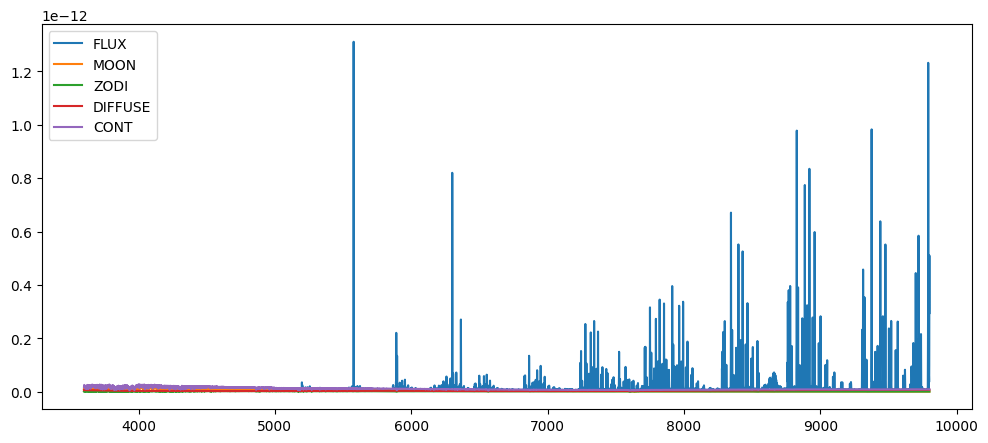

In [6]:
from matplotlib import pyplot as plt

skymodel = get_skymodel(tbl[idx])

print(skymodel.columns)

plt.figure(figsize=(12, 5))
plt.plot(skymodel['WAVE'], skymodel['FLUX'], label='FLUX')
plt.plot(skymodel['WAVE'], skymodel['MOON'], label='MOON')
plt.plot(skymodel['WAVE'], skymodel['ZODI'], label='ZODI')
plt.plot(skymodel['WAVE'], skymodel['DIFFUSE'], label='DIFFUSE')
plt.plot(skymodel['WAVE'], skymodel['CONT'], label='CONT')
plt.legend()
plt.show()

## Create Design matrix

In [7]:
design_matrix = np.zeros((len(lines_groups), wave.size), dtype=float)

lsf_sigma = 1.3 / 2.355

for i, group in enumerate(lines_groups):
    wave_group = group['wave']
    flux_group = group['flux']

    for wave_line, flux_line in zip(wave_group, flux_group):
        if (wave_line >= wave[0]) & (wave_line <= wave[-1]):
            yy = (wave - wave_line) / lsf_sigma
            design_matrix[i] += flux_line * np.exp(-0.5 * yy ** 2)

## Decomposition

[1.36292211e+00 5.71244920e-01 2.95884930e+00 9.97254609e+00
 5.36858912e-17 2.26813172e+00 8.11947455e+00 2.03669472e+00
 1.79057294e+00 1.64977278e+00 7.14701878e+00 1.82746699e+00
 1.62802173e+00 1.64779207e+00 1.41678294e+00 1.19323597e+00
 8.42893322e-19 1.70945595e+00 1.24766195e+00 1.16071561e+00
 1.04652049e+00 1.17974885e+00 1.00000000e-01 5.29527606e-01
 6.57851216e-17 4.28944036e-17 3.36812643e-17 1.14538932e-16
 3.34601714e+00 3.61395686e+00 9.86678954e-01]


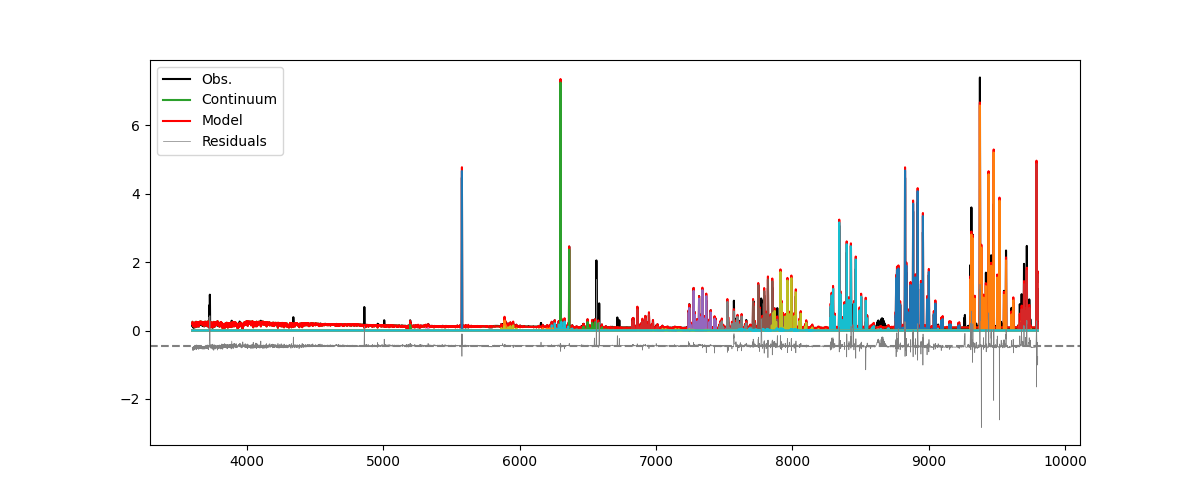

In [10]:
from scipy.optimize import lsq_linear

factor = 1e-13

continuum_matrix = np.vstack( (
    skymodel['MOON'] / factor,
    skymodel['ZODI'] / factor,
    skymodel['DIFFUSE'] / factor,
) )

# `skymodel` also contains `CONT` component, but above definition is more
# flexible in case independent component fitting is needed.
cont_spec = np.sum(continuum_matrix, axis=0)

design_matrix_complete = np.vstack( (design_matrix, cont_spec) )

bounds = (0, np.inf) # requiring only positive values
results = lsq_linear(design_matrix_complete.T, spec / factor, bounds=bounds)
coef = results.x
print(coef)

model_lines = np.dot(design_matrix.T, coef[:-1])
model_cont = cont_spec * coef[-1]


###############################################################################
# plotting the line groups
model = model_lines + model_cont
resid = spec / factor - model
rms = np.std(resid)


%matplotlib widget
# %matplotlib inline

plt.close()
plt.figure(figsize=(12, 5))
plt.plot(wave, spec / factor, color='k', label='Obs.')

plt.plot(wave, model_cont, color='C2', label='Continuum')
plt.plot(wave, model, color='red', label='Model')
for i, grp_spec in enumerate(design_matrix):
    plt.plot(wave, grp_spec * coef[i], '-')

resid_level = -5 * rms
plt.axhline(resid_level, color='gray', linestyle='--')
plt.plot(wave, resid_level + resid, color='gray', lw=0.5, label='Residuals')
plt.legend()
plt.show()

---

## Outdate backups

In [87]:
from numpy.polynomial.legendre import legval
from numpy.polynomial.legendre import legvander

from matplotlib import pyplot as plt
from astropy.convolution import Gaussian1DKernel, convolve

sun, header = fits.getdata("/Users/ik52/sci/IDL_libs/ULySS/v1.3/ulyss/models/sun.fits", header=True)
sun_wave = header['CRVAL1'] + np.arange(len(sun)) * header['CDELT1']

cdelt = header['CDELT1']

lsf_fwhm = 1.5 # in Angstrom
lsf_sigma = lsf_fwhm / 2.35 / cdelt  # in pixels

print("LSF sigma in pixels:", lsf_sigma)

kernel = Gaussian1DKernel(stddev=lsf_sigma, mode='oversample', factor=10)
sun_smoothed = convolve(sun, kernel, boundary='extend')

spec_sun = np.interp(wave, sun_wave, sun_smoothed)

plt.close()
plt.plot(sun_wave, sun)
plt.plot(sun_wave, sun_smoothed, label='smoothed', color='orange')
plt.plot(wave, spec_sun, label='interpolated', color='red')

spec_sun = spec_sun / np.median(spec_sun)

LSF sigma in pixels: 3.191489361702127


In [ ]:
from scipy.optimize import lsq_linear
from numpy.polynomial.legendre import legval
from numpy.polynomial.legendre import legvander


n_order = 13  # maximum Legendre order
x = np.linspace(-1, 1, spec_sun.size)
L = legvander(x, n_order)  # shape (N, n_order+1)
mpoly_basis = (L.T * spec_sun).astype(float)  # shape (n_order+1, N)

design_matrix_complete = np.vstack( (design_matrix, spec_sun) )

factor = 1e-13
# bounds = (0, np.inf)  # non-negative coefficients
bounds = (-np.inf, np.inf)  # allow negative coefficients
results = lsq_linear(design_matrix_complete.T, spec / factor, bounds=bounds)
coef = results.x

model_sun = np.dot(mpoly_basis.T, coef[-n_order-1:])

print(coef)

###############################################################################
# plotting the line groups
model = np.dot(design_matrix_complete.T, coef)
resid = spec / factor - model
rms = np.std(resid)

plt.close()
plt.figure(figsize=(12, 5))
plt.plot(wave, spec / factor, color='k', label='Obs.')

for i, grp_spec in enumerate(design_matrix):
    plt.plot(wave, grp_spec * coef[i], '-')

plt.plot(wave, model_sun, color='C2', label='Sun')
plt.plot(wave, model, color='red', label='Model')

resid_level = -5 * rms
plt.axhline(resid_level, color='gray', linestyle='--')
plt.plot(wave, resid_level + resid, color='gray', lw=0.5, label='Residuals')
plt.legend()
plt.show()